# DPM & MFM Roundup

## Methods
Default parameters:
- All DPM methods default to alpha=1.0 unless otherwise specified.
- All MFM methods default to using a poisson(k) prior unless otherwise specified.

| name | description |
|--|--|
| dpm_gibbs | DPM using gibbs sampler |
| dpm_sm | DPM using split merge only |
| dpm_hybrid | DPM using hybrid (5,1) sampler |
| dpm_eb | DPM using empirical bayes updates |
| dpm_eb_gibbs | DPM using empirical bayes updates and gibbs sampling only |
| dpm_small_alpha | DPM using alpha=0.1 |
| dpm_big_alpha | DPM using alpha=10 |
| mfm_gibbs | MFM using gibbs sampler |
| mfm_sm | MFM using split merge only |
| mfm_hybrid | MFM using hybrid (5,1) sampler |
| mfm_prior_low | MFM with a poisson(k - 2) prior |
| mfm_prior_high | MFM with a poisson(k + 2) prior |

## Definitions
- NMI: Normalized Mutual Information
- Rand score: Adjusted Rand Index
- Aggregation score: measure of tendency to cluster points that should be in the same cluster together:
$$\mathbb{P}[\mathbf{z}_i = \mathbf{z}_j | \mathbf{Z}_i = \mathbf{Z}_j]$$
- Segregation score: measure of tendency to separate points that should be in different clusters:
$$\mathbb{P}[\mathbf{z}_i \neq \mathbf{z}_j | \mathbf{Z}_i \neq \mathbf{Z}_j]$$
- Oracle: clustering algorithm with perfect knowledge of model parameters (i.e. cluster means, weights, covariance) but no knowledge of individual point assignments
- Oracle Normalized (metric): metric normalized by dividing the algorithm score by the oracle clustering score on that metric
- EB: abbreviation for empirical bayes

## Columns
|column|description|
|--|--|
| rand | Rand score of result |
| nmi | NMI score of result |
| oracle_rand | Rand score of Oracle clustering |
| oracle_nmi | NMI of Oracle clustering |
| num_clusters | Number of clusters in result |
| best_idx | Index of 'best' configuration according to least squares. Useful for loading the clustering configuration without recomputing the least squares configuration. |
| aggregation | Aggregation score |
| segregation | Segregation score |
| oracle_aggregation | Oracle aggregation score |
| oracle_segregation | Oracle segregation score |
| iterations | Number of iterations run. NOTE: runs where the number of clusters 'blew up' (>100) were terminated, and are reflected here. |
| method | Method used. See the 'methods' section. |
| d | Number of dimensions |
| p | Number of points |
| k | Number of clusters |
| r | Ratio of weights; the nth cluster has weight proportional to $r^n$. |
| id | Run ID (uuid4) |


## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
COLUMNS = {
    'rand': np.float64,
    'nmi': np.float64,
    'oracle_rand': np.float64,
    'oracle_nmi': np.float64,
    'num_clusters': np.uint16,
    'best_idx': np.uint16,
    'aggregation': np.float64,
    'segregation': np.float64,
    'oracle_aggregation': np.float64,
    'oracle_segregation': np.float64,
    'iterations': np.uint16,
    'method': str,
    'd': np.uint16,
    'p': np.uint16,
    'k': np.uint16,
    'r': np.float64,
    'id': str
}

In [3]:
SCORES = {
    'rand': "Rand Score",
    'nmi': "NMI",
    'aggregation': "Aggregation Score",
    'segregation': "Segregation Score"
}

In [4]:
METHODS = {
    'mfm_prior_high': "MFM: poisson(k + 2)",
    'mfm_hybrid': "MFM: (5,1) hybrid",
    'mfm_prior_low': "MFM: poisson(k - 2)",
    'mfm_gibbs': "MFM: gibbs",
    'mfm_sm': "MFM: split merge",
    'mfm_hybrid_3': "MFM: (3,1) hybrid",
    'mfm_hybrid_10': "MFM: (10,1) hybrid",
    'dpm_small_alpha': "DPM: alpha=0.1",
    'dpm_hybrid': "DPM: (5,1) hybrid",
    'dpm_big_alpha': "DPM: alpha=10",
    'dpm_sm': "DPM: split merge",
    'dpm_gibbs': "DPM: gibbs",
    'dpm_eb': "DPM: EB",
    'dpm_eb_gibbs': "DPM: EB, gibbs"
}

In [5]:
summary = pd.read_csv('summary.csv', dtype=COLUMNS)

In [6]:
TESTS = summary[['d', 'p', 'k']].drop_duplicates()

In [7]:
def filter(df, **kwargs):
    for k, v in kwargs.items():
        df = df[df[k] == v]
    return df

## Plots

In [56]:
import math
import matplotlib


def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (math.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.latex.unicode': True,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax


In [8]:
def oracle_ratio(key='rand', **kwargs):
    df = filter(summary, **kwargs)

    return list(df[key] / df['oracle_'+ key])

In [70]:
def get_data(test, key, sortstat=np.mean, sortkey=None, methods=METHODS):

    data = [oracle_ratio(method=m, key=key, **test) for m in methods.keys()]
    
    sortlist = [
        sortstat(d) for d in (
            data if sortkey is None else
            [oracle_ratio(method=m, key=sortkey, **test) for m in methods.keys()]
        )]
    
    labels = [v for k, v in methods.items()]
    
    return list(zip(*sorted(zip(sortlist, data, labels))))
    

In [10]:
def get_title(test, key, plot):
    return (
        "{d:d} Dimensions, {p:d} Points, {k:d} Clusters"
        "  |  Oracle Normalized {metric}"
        "  |  {plot}".format(metric=SCORES.get(key, key), plot=plot, **test))

def get_filename(test, key, plot):
    return (
        "./plots/d={d},p={p},k={k},metric={metric},plot={plot}.pdf".format(
            metric=key, plot=plot, **test))

In [11]:
def boxplot(key, t, ax, sortkey=None):

    median, data, labels = get_data(t, key, sortstat=np.median, sortkey=sortkey)
    colors = ['C0' if b.startswith('DPM') else 'C1' for b in labels]

    bp = ax.boxplot(data, 0, '.', vert=False, patch_artist=True)
    for box, color in zip(bp['boxes'], colors):
        box.set(color=color)
    plt.setp(bp['medians'], color='black')

    ax.yaxis.grid()
    ax.set_yticklabels(labels)
    
    
def boxplots(key, title=True, save=False):
    for _, t in TESTS.iterrows():
        fig, ax = plt.subplots(1, 1)
        
        if title:
            ax.set_title(get_title(t, key, plot='Boxplots, sorted by median'))
        boxplot(key, t, ax)
        if save:
            plt.savefig(get_filename(t, key, "boxplot"), bbox_inches='tight')

In [12]:
from scipy import stats

MIN_VAL = 0.8


def se_interval(key, t, ax, sortkey=None):

    means, data, labels = get_data(t, 'rand', sortstat=np.mean, sortkey=sortkey)
    stderr = [stats.sem(d) * 2 for d in data]
    colors = ['C0' if b.startswith('DPM') else 'C1' for b in labels]

    for idx, (mean, err, color) in enumerate(zip(means, stderr, colors)):
        ax.errorbar([mean], [idx], xerr=[err], fmt='o', color=color, capsize=5)
        if mean + err < MIN_VAL:
            ax.arrow(MIN_VAL + 0.01, idx, -0.005, 0, color=color, head_width=0.3, head_length=0.002)

    ax.yaxis.grid()
    ax.yaxis.set_ticks(np.arange(len(METHODS)))
    ax.set_xlim(0.8, 1)
    ax.set_yticklabels(labels)

    
def se_intervals(key, title=True, save=False):
    for _, t in TESTS.iterrows():
        fig, ax = plt.subplots(1, 1)
        
        if title:
            ax.set_title(get_title(t, key, plot='Mean and 2SE intervals, sorted by median'))
        se_interval(key, t, ax)
        if save:
            plt.savefig(get_filename(t, key, "se_intervals"), bbox_inches='tight')


In [14]:
def ag_sg(t, fig, left, right):

    fig.tight_layout()
    boxplot('aggregation', t, left, sortkey='rand')
    boxplot('segregation', t, right, sortkey='rand')
    plt.setp(right.get_yticklabels(), visible=False)
    left.set_title("Aggregation Score")
    right.set_title("Segregation Score")

def ag_sg_all():
    for _, t in TESTS.iterrows():
        fig, (left, right) = plt.subplots(1, 2)
        fig.suptitle(
            "{d:d} Dimensions, {p:d} Points, {k:d} Clusters"
            "  |  Sorted by Rand Score".format(**t), y=1.05, fontsize=16)

        ag_sg(t, fig, left, right)


In [190]:
latexify(columns=2)

d       3
p    1200
k       5
Name: 200, dtype: uint16


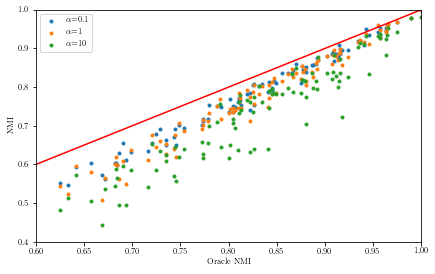

In [90]:
DPM_ALPHA_METHODS = {
    "dpm_small_alpha": 0.1,
    "dpm_hybrid": 1,
    "dpm_big_alpha": 10,
}


def scatter_alpha(t):

    fig, ax = plt.subplots(1, 1)

    minx = 1
    miny = 1
    for method, alpha in DPM_ALPHA_METHODS.items():
        df = filter(summary, method=method, **t)
        ax.scatter(df['oracle_nmi'], df['nmi'], marker='.', label=r"$\alpha$={}".format(alpha))
        minx = min(min(df['oracle_nmi']), minx)
        miny = min(min(df['nmi']), miny)

    st = max(minx, miny)
    ax.set_xlim(0.6, 1)
    ax.set_ylim(0.4, 1)
    ax.plot([st, 1], [st, 1], color='red')
    ax.set_xlabel('Oracle NMI')
    ax.set_ylabel('NMI')
    ax.legend()
    
    plt.savefig('d=3,p=1200,k=5,metric=nmi,plot=scatter.pdf', bbox_inches='tight')


scatter_alpha(TESTS.iloc[2])
print(TESTS.iloc[2])
    

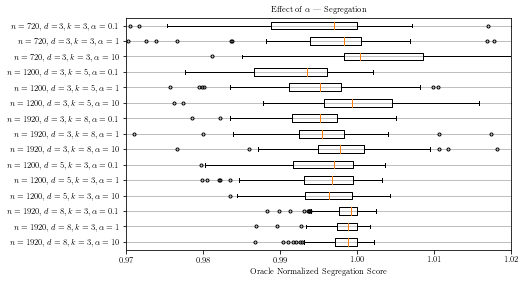

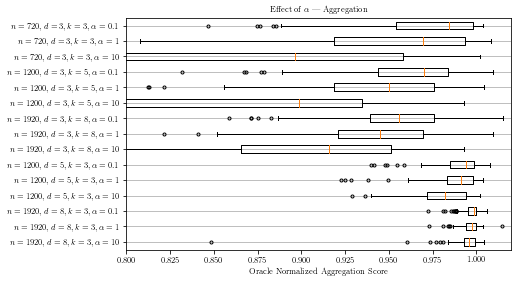

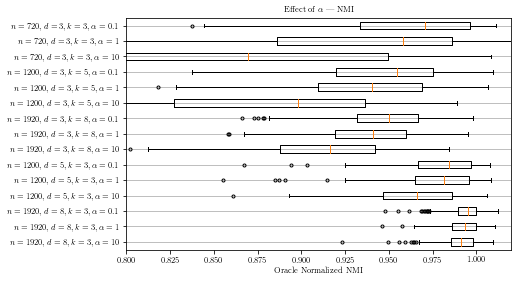

In [153]:
def boxplots_alpha(fig, ax, key):
    ax.yaxis.grid()

    data = []
    labels = []
    for d, k in [(3, 3), (3, 5), (3, 8), (5, 3), (8, 3)]:
        data += [
            oracle_ratio(method=m, key=key, d=d, k=k, p=d * k * 80)
            for m in DPM_ALPHA_METHODS]
        labels += [
            r"$n={}, d={}, k={}, \alpha={}$".format(d * k * 80, d, k, alpha)
            for _, alpha in DPM_ALPHA_METHODS.items()]
    
    data.reverse()
    labels.reverse()
    
    ax.boxplot(data, 0, '.', vert=False)
    ax.set_yticklabels(labels)
    

fig, ax = plt.subplots(1, 1)
boxplots_alpha(fig, ax, 'segregation')
ax.set_xlim(0.97, 1.02)
ax.set_title(r'Effect of $\alpha$ | Segregation')
ax.set_xlabel('Oracle Normalized Segregation Score')
fig.savefig('effect_alpha_segregation.pdf', bbox_inches='tight')

fig, ax = plt.subplots(1, 1)
boxplots_alpha(fig, ax, 'aggregation')
ax.set_xlim(0.8, 1.02)
ax.set_title(r'Effect of $\alpha$ | Aggregation')
ax.set_xlabel('Oracle Normalized Aggregation Score')
fig.savefig('effect_alpha_aggregation.pdf', bbox_inches='tight')

fig, ax = plt.subplots(1, 1)
boxplots_alpha(fig, ax, 'nmi')
ax.set_xlim(0.8, 1.02)
ax.set_title(r'Effect of $\alpha$ | NMI')
ax.set_xlabel('Oracle Normalized NMI')
fig.savefig('effect_alpha_nmi.pdf', bbox_inches='tight')


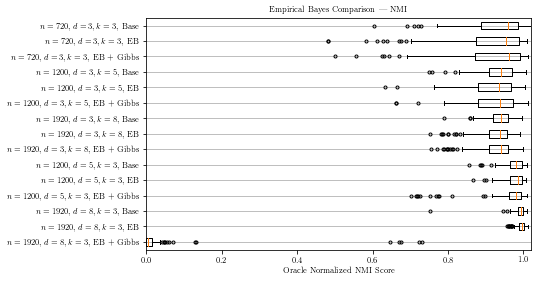

In [197]:
EB_METHODS = {
    "dpm_hybrid": "Base",
    "dpm_eb": "EB",
    "dpm_eb_gibbs": "EB + Gibbs"
}

def boxplots_eb(fig, ax, key):
    ax.yaxis.grid()

    data = []
    labels = []
    for d, k in [(3, 3), (3, 5), (3, 8), (5, 3), (8, 3)]:
        data += [
            oracle_ratio(method=m, key=key, d=d, k=k, p=d * k * 80)
            for m in EB_METHODS]
        labels += [
            r"$n={}, d={}, k={},$ {}".format(d * k * 80, d, k, desc)
            for _, desc in EB_METHODS.items()]
    
    data.reverse()
    labels.reverse()
    
    ax.boxplot(data, 0, '.', vert=False)
    ax.set_yticklabels(labels)

fig, ax = plt.subplots(1, 1)
boxplots_eb(fig, ax, 'nmi')
ax.set_title('Empirical Bayes Comparison | NMI')
ax.set_xlabel('Oracle Normalized NMI Score')
ax.set_xlim(0, 1.02)
fig.savefig('effect_eb_nmi.pdf', bbox_inches='tight')

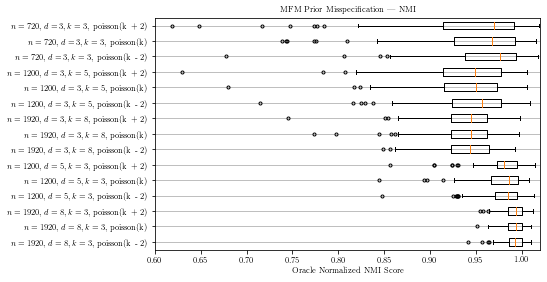

In [198]:
MFM_PRIORS = {
    "mfm_prior_high": "poisson(k + 2)",
    "mfm_hybrid": "poisson(k)",
    "mfm_prior_low": "poisson(k - 2)",
}

def boxplots_prior(fig, ax, key):
    ax.yaxis.grid()

    data = []
    labels = []
    for d, k in [(3, 3), (3, 5), (3, 8), (5, 3), (8, 3)]:
        data += [
            oracle_ratio(method=m, key=key, d=d, k=k, p=d * k * 80)
            for m in MFM_PRIORS]
        labels += [
            r"$n={}, d={}, k={},$ {}".format(d * k * 80, d, k, desc)
            for _, desc in MFM_PRIORS.items()]
    
    data.reverse()
    labels.reverse()
    
    ax.boxplot(data, 0, '.', vert=False)
    ax.set_yticklabels(labels)

fig, ax = plt.subplots(1, 1)
boxplots_prior(fig, ax, 'nmi')
ax.set_title('MFM Prior Misspecification | NMI')
ax.set_xlabel('Oracle Normalized NMI Score')
ax.set_xlim(0.6, 1.02)
fig.savefig('effect_mfm_prior.pdf', bbox_inches='tight')

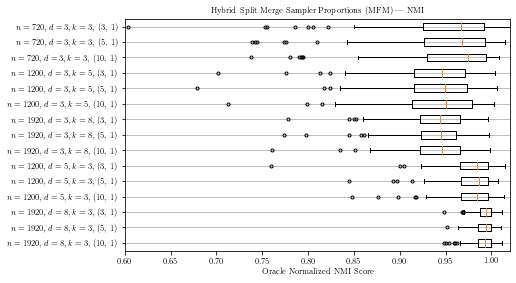

In [201]:
SM_SCHEMES = {
    "mfm_hybrid_3": "(3, 1)",
    "mfm_hybrid": "(5, 1)",
    "mfm_hybrid_10": "(10, 1)",
}

def boxplots_hybrid(fig, ax, key):
    ax.yaxis.grid()

    data = []
    labels = []
    for d, k in [(3, 3), (3, 5), (3, 8), (5, 3), (8, 3)]:
        data += [
            oracle_ratio(method=m, key=key, d=d, k=k, p=d * k * 80)
            for m in SM_SCHEMES]
        labels += [
            r"$n={}, d={}, k={},$ {}".format(d * k * 80, d, k, desc)
            for _, desc in SM_SCHEMES.items()]
    
    data.reverse()
    labels.reverse()
    
    ax.boxplot(data, 0, '.', vert=False)
    ax.set_yticklabels(labels)

fig, ax = plt.subplots(1, 1)
boxplots_hybrid(fig, ax, 'nmi')
ax.set_title('Hybrid Split Merge Sampler Proportions (MFM) | NMI')
ax.set_xlabel('Oracle Normalized NMI Score')
ax.set_xlim(0.6, 1.02)
fig.savefig('effect_hybrid.pdf', bbox_inches='tight')

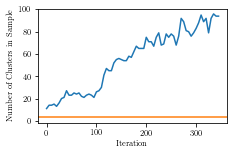

In [189]:
import bmcc

BASE = 'd=8,p=1920,k=3,r=0.8/794c1531-6a0f-4d79-a89c-e4c004425d21.npz'

dataset = bmcc.GaussianMixture('./data/' + BASE, load=True)
hist = np.load('./results/dpm_eb_gibbs/' + BASE)['hist']

# res = bmcc.LstsqResult(dataset.data, hist, burn_in=int(hist.shape[0] / 2))
# res.evaluate(dataset.assignments, oracle=dataset.oracle, oracle_matrix=None)

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(hist.shape[0]) * 5, [np.max(x) for x in hist])
ax.axhline(3, color='C1')
ax.set_xlabel('Iteration')
ax.set_ylabel('Number of Clusters in Sample')

fig.savefig('794c1531-6a0f-4d79-a89c-e4c004425d21_nc.pdf', bbox_inches='tight')

In [35]:
FIG_TEXT = r"""
\begin{{figure}}[H]
    \centering
    \includegraphics[width=0.8\textwidth]{{plots/d={d},p={p},k={k},metric={metric},plot={plot}.pdf}}
    \caption{{{metric_desc} | {d} Dimensions, {k} Clusters ({p} Points) | {plot_desc}}}
    \label{{fig:{metric}_d{d}_k{k}_{plot}}}
\end{{figure}}"""

for d, k in [(3, 3), (3, 5), (3, 8), (5, 3), (8, 3)]:
    for plot, desc in [('boxplot', 'Boxplot of 100 Runs'), ('se_intervals', '2SE Intervals; arrow denotes intervals less than 0.8')]:
        for metric, metric_desc in [('rand', 'Oracle Normalized Rand Score'), ('nmi', 'Oracle Normalized NMI')]:
            print(FIG_TEXT.format(
                d=d, k=k, p=d * k * 80, plot=plot,
                metric=metric, metric_desc=metric_desc, plot_desc=desc))



\begin{figure}[H]
    \centering
    \includegraphics[width=0.8\textwidth]{plots/d=3,p=720,k=3,metric=rand,plot=boxplot.pdf}
    \caption{Oracle Normalized Rand Score | 3 Dimensions, 3 Clusters (720 Points) | Boxplot of 100 Runs}
    \label{fig:rand_d3_k3_boxplot}
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=0.8\textwidth]{plots/d=3,p=720,k=3,metric=nmi,plot=boxplot.pdf}
    \caption{Oracle Normalized NMI | 3 Dimensions, 3 Clusters (720 Points) | Boxplot of 100 Runs}
    \label{fig:nmi_d3_k3_boxplot}
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=0.8\textwidth]{plots/d=3,p=720,k=3,metric=rand,plot=se_intervals.pdf}
    \caption{Oracle Normalized Rand Score | 3 Dimensions, 3 Clusters (720 Points) | 2SE Intervals; arrow denotes intervals less than 0.8}
    \label{fig:rand_d3_k3_se_intervals}
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=0.8\textwidth]{plots/d=3,p=720,k=3,metric=nmi,plot=se_intervals.pdf}

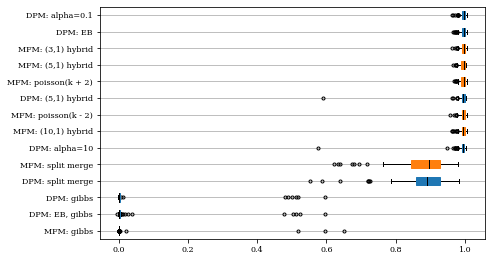

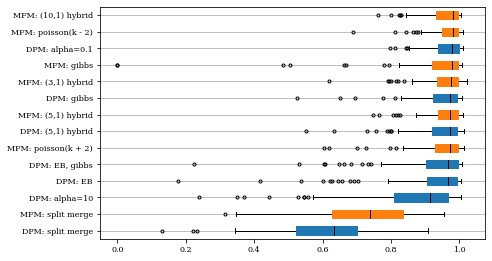

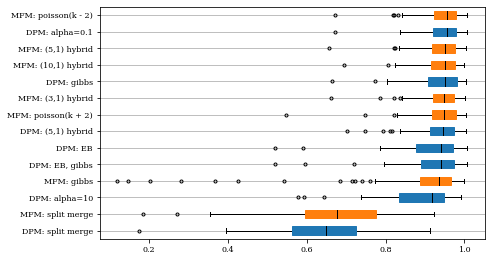

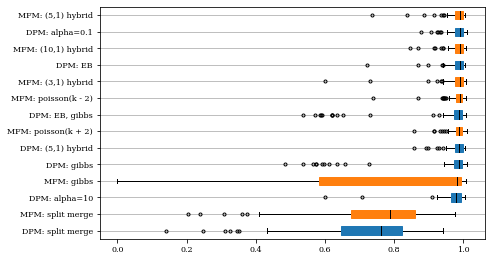

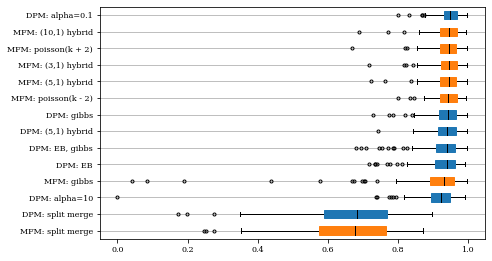

In [19]:
boxplots('rand', title=False, save=True)

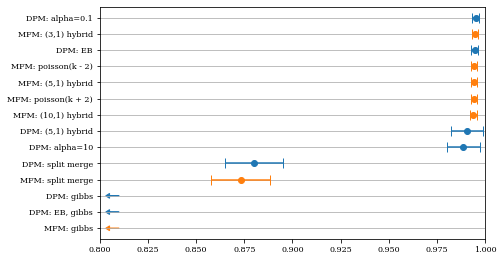

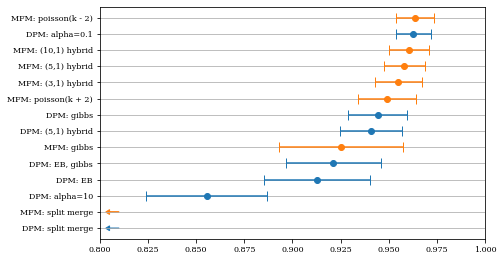

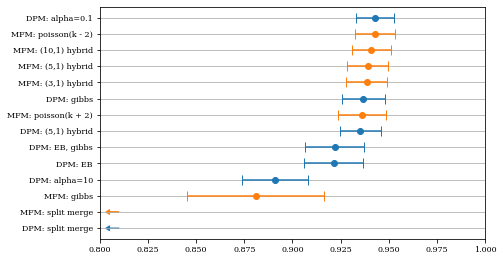

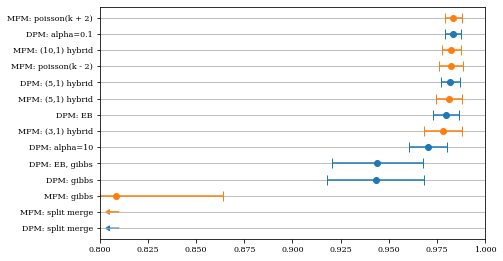

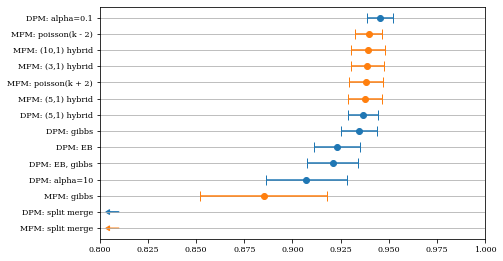

In [20]:
se_intervals('rand', title=False, save=True)